In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from fbprophet import Prophet

In [2]:
cp_df = pd.read_excel('../Price Predictor/data.xlsx')
cp_df.head(5)

,sku,L1,L2,L3,product_name,date,quantity,price
0,100003005,SNACKS & BRANDED FOODS,SNACKS & NAMKEEN,CHIPS & CORN SNACKS,ACT II MICROWAVE POPCORN - NATURAL,2016-09-16,131958,1173
1,100003379,"FOODGRAINS, OIL & MASALA",EDIBLE OILS & GHEE,OTHER EDIBLE OILS,TIL SONA OIL - TIL,2016-09-16,681155,5426
2,100003486,"FOODGRAINS, OIL & MASALA",EDIBLE OILS & GHEE,OTHER EDIBLE OILS,IDHAYAM OIL - SESAME,2016-09-16,141932,4850
3,100003586,"FOODGRAINS, OIL & MASALA",EDIBLE OILS & GHEE,GHEE & VANASPATI,GOWARDHAN PREMIUM GHEE,2016-09-16,375838,3430
4,100003775,SNACKS & BRANDED FOODS,"NOODLE, PASTA, VERMICELLI",INSTANT NOODLES,TOP RAMEN NOODLES - CHICKEN,2016-09-16,269178,3866


In [3]:
cp_df.dtypes

sku              int64
L1              object
L2              object
L3              object
product_name    object
date            object
quantity         int64
price            int64
dtype: object

In [4]:
# Since date is not of datetime type
cp_df['date'] = pd.DatetimeIndex(cp_df['date'])
cp_df.dtypes

sku                      int64
L1                      object
L2                      object
L3                      object
product_name            object
date            datetime64[ns]
quantity                 int64
price                    int64
dtype: object

In [5]:
trial_cp_df = cp_df.loc[cp_df['sku'] == 100003967]
trial_cp_df = trial_cp_df[['date','price']]
trial_cp_df.set_index('date', inplace=True)

In [6]:
trial_cp_df.head(5)

,price
date,
2016-09-16,4514
2016-10-25,3811
2016-11-26,1460
2016-12-24,5991
2017-01-24,343


In [7]:
#plt.plot(trial_cp_df)

ts = trial_cp_df['price']
ts.head(10)

date
2016-09-16    4514
2016-10-25    3811
2016-11-26    1460
2016-12-24    5991
2017-01-24     343
2017-02-26    2152
2017-03-27     552
2017-04-21     618
2017-05-22    1721
2017-06-24    4629
Name: price, dtype: int64

In [8]:
# Function to test stationarity

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    # Option 1 - visual inspection of rolling mean and rolling std
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Option 2 - Perform Dickey-Fuller test
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [ ]:
# Option 1 - Differencing - Not required here as the output is stationary (Preferred Option)
#ts_diff = ts - ts.shift()
#plt.plot(ts_diff)
#test_stationarity(ts_diff)

In [ ]:
# Option 2 - Decomposing - Not required here as the output is stationary
#from statsmodels.tsa.seasonal import seasonal_decompose
#decomposition = seasonal_decompose(ts)

#trend = decomposition.trend
#seasonal = decomposition.seasonal
#residual = decomposition.resid

#plt.subplot(411)
#plt.plot(ts, label='Original')
#plt.legend(loc='best')
#plt.subplot(412)
#plt.plot(trend, label='Trend')
#plt.legend(loc='best')
#plt.subplot(413)
#plt.plot(seasonal,label='Seasonality')
#plt.legend(loc='best')
#plt.subplot(414)
#plt.plot(residual, label='Residuals')
#plt.legend(loc='best')
#plt.tight_layout()

#ts_decompose = residual
#test_stationarity(ts_decompose)

In [16]:
# Convert time series to dataframe and rename columns as per Prophet requirement - 'ds' and 'y'
ts_df = pd.DataFrame({'ds':ts.index, 'y':ts.values})
ts_df.head(5)

In [9]:
# Time series forecasting using Prophet
# set the uncertainty interval to 95% (the Prophet default is 80%)
cp_fs_model = Prophet(changepoint.prior.scale = 0.55,seasonality_prior_scale=0.1,interval_width=0.95)

In [18]:
cp_fs_model.fit(ts_df)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.
C:\Users\pmanjunath\AppData\Local\Continuum\anaconda3\lib\site-packages\fbprophet\forecaster.py:353: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  np.linspace(0, hist_size - 1, self.n_changepoints + 1)
C:\Users\pmanjunath\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [19]:
# Prophet has a built-in helper function make_future_dataframe to create a dataframe of future date
future_dates_df = cp_fs_model.make_future_dataframe(periods=12, freq='MS')

In [23]:
forecasted_cp_df = cp_fs_model.predict(future_dates_df)
forecasted_cp_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-09-16,2877.932881,1523.015462,7874.951754,2877.932881,2877.932881,1895.718929,1895.718929,1895.718929,1895.718929,1895.718929,1895.718929,0.0,0.0,0.0,4773.651810
1,2016-10-25,2878.962945,-993.561182,5415.181277,2878.962945,2878.962945,-559.463606,-559.463606,-559.463606,-559.463606,-559.463606,-559.463606,0.0,0.0,0.0,2319.499339
2,2016-11-26,2879.808125,272.417843,6608.648615,2879.808125,2879.808125,478.593139,478.593139,478.593139,478.593139,478.593139,478.593139,0.0,0.0,0.0,3358.401264
3,2016-12-24,2880.547658,140.782465,6332.224054,2880.547658,2880.547658,271.029409,271.029409,271.029409,271.029409,271.029409,271.029409,0.0,0.0,0.0,3151.577067
4,2017-01-24,2881.366427,-539.651237,5748.258854,2881.366427,2881.366427,-288.817371,-288.817371,-288.817371,-288.817371,-288.817371,-288.817371,0.0,0.0,0.0,2592.549056


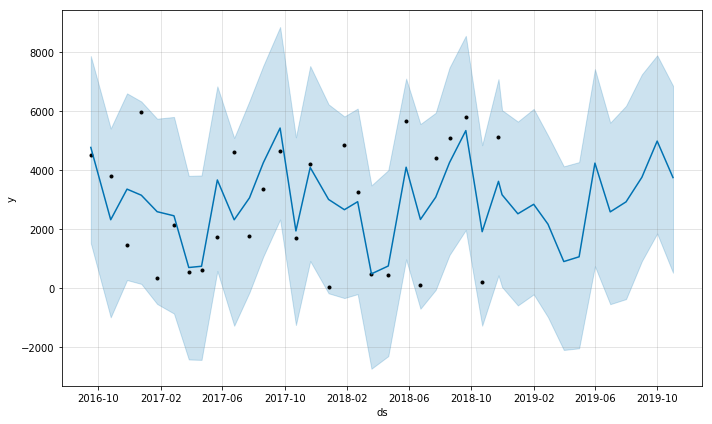

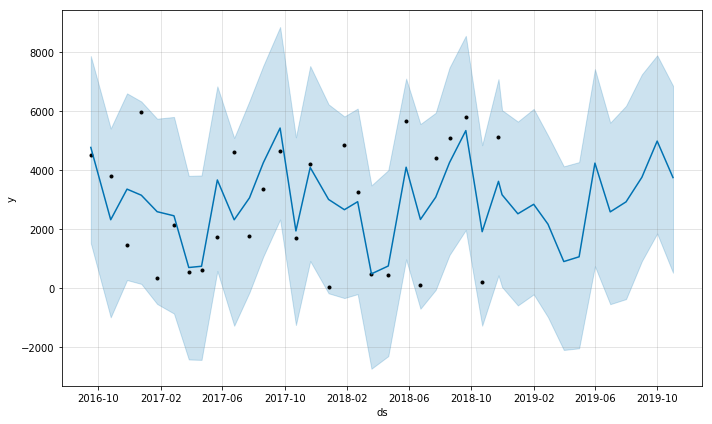

In [28]:
# Function in Prophet to plot the results of our forecasts

# Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and 
# the uncertainty intervals of our forecasts (the blue shaded regions).
cp_fs_model.plot(forecasted_cp_df, uncertainty=True)

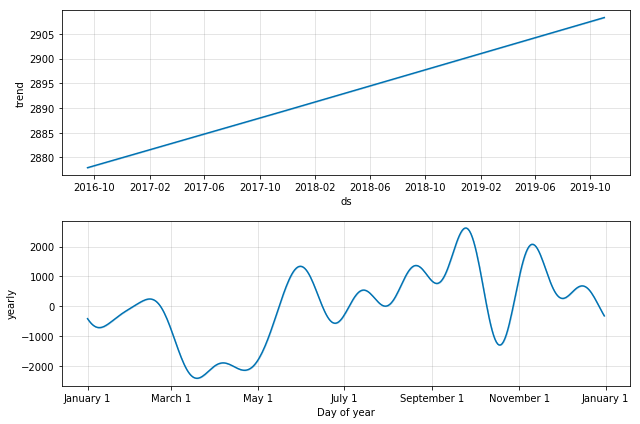

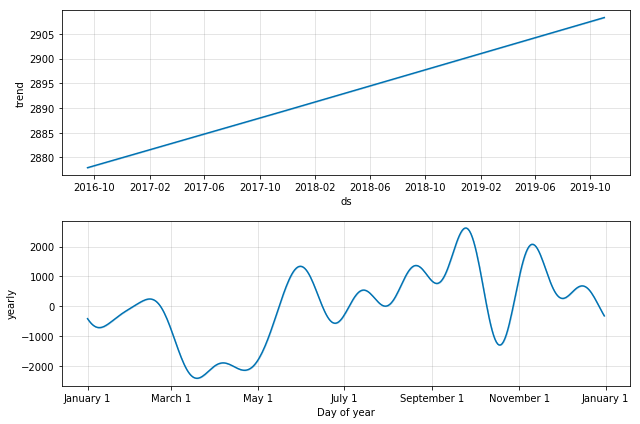

In [29]:
cp_fs_model.plot_components(forecasted_cp_df)